![image](https://raw.githubusercontent.com/Lexie88rus/augmentation-packages-overview/master/images/art-assorted-background.jpg)

_Photo by rawpixel.com from Pexels_

# Image Augmentation for Deep Learning
### _Overview of popular augmentation packages and PyTorch examples_

In [1]:
# Import utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

# Import Image manipulation
from PIL import Image

# Import data visualization
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

['image1.jpg', 'mask1.png']


In [2]:
! pip install augmentor

In [3]:
! pip install albumentations

## Introduction

Having a large dataset is crucial for performance of the deep learning model. However, we can improve the performance of the model by [augmenting the data we already have](https://bair.berkeley.edu/blog/2019/06/07/data_aug/). Deep learning frameworks usually have built-in data augmentation utilities (like torchvision transformations in PyTorch), but those can be unefficient or lacking some required functionality (like mask augmentation).

In this kernel I would like to make an overview of most popular data augmentation packages, designed specifically for machine learning, and demonstrate how to use these packages with PyTorch.

## Load Demo Images

Let's load and look at the sample image for the demonstration:

`1. Image for classification:`

In [4]:
# load sample dog image
dog_img = Image.open('../input/image1.jpg')

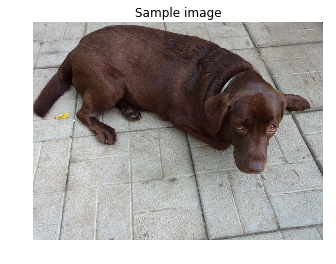

In [5]:
# show the demo image
plt.title('Sample image')
plt.axis('off')
plt.imshow(dog_img)

`2. Image and mask for segmentation:`

In [6]:
# load mask for sample dog image
dog_mask = Image.open('../input/mask1.png')

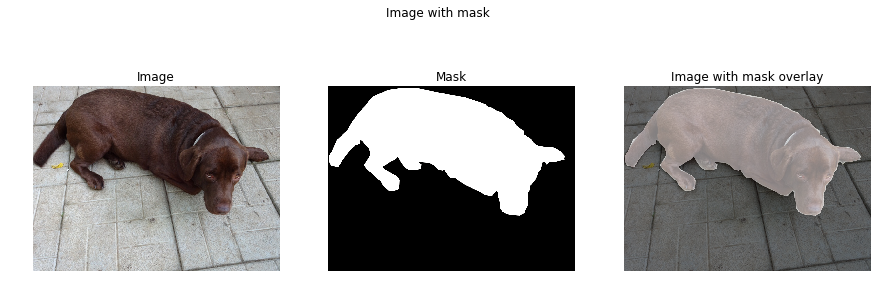

In [7]:
# define a function plot image and mask
def plot_image_and_mask(image, mask):
    '''
    Function to plot a single prediction:
    INPUT:
        image - PIL image 
        mask - PIL image with corresponding mask
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    #plot the original data
    axs[0].imshow(image) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow(mask)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    plt.suptitle('Image with mask')
    plt.show()

# plot image and a mask
plot_image_and_mask(dog_img, dog_mask)

`3. Image and bounding box for object detection`:

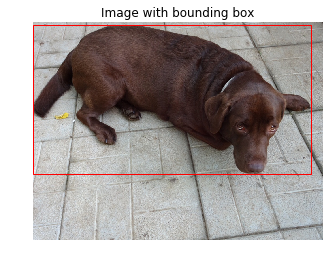

In [8]:
# sample code from
# https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(dog_img)

# Create a Rectangle patch
rect = patches.Rectangle((0,9),980,525,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.axis('off') # disable axis

plt.title('Image with bounding box')
plt.show()

## imgaug package

__[imgaug](https://github.com/aleju/imgaug)__ is an extremely powerful package for image augmentation. It contains:
* Over 40 image augmentors and augmentation techniques;
* Functionality to augment images with masks, bounding boxes, keypoints and heatmaps. This functionality makes it very easy to augment the dataset containing images for segmentation and object detection problems;
* Complex augmentation pipelines;
* Many helper functions for augmentation visualization, convertion, and more.

You can find full documentation for __imgaug__ [here](https://imgaug.readthedocs.io/en/latest/index.html).

`1.` Simple image augmentation examples:

In [9]:
! pip install --upgrade imgaug

     |████████████████████████████████| 757kB 1.4MB/s 
ERROR: albumentations 0.3.0 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


In [10]:
# import the library and helpers
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

Augmentation of a single image:

In [11]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = imageio.imread('../input/image1.jpg')

# initialize the augmenters for demo
rotate = iaa.Affine(rotate=(-25, 25)) # rotate image
gaussian_noise = iaa.AdditiveGaussianNoise(scale=(10, 60)) # add gaussian noise
crop = iaa.Crop(percent=(0, 0.4)) # crop image
hue = iaa.AddToHueAndSaturation((-60, 60))  # change their color
elastic_trans = iaa.ElasticTransformation(alpha=90, sigma=9) # water-like effect
coarse_drop = iaa.CoarseDropout((0.01, 0.1), size_percent=0.01)# set large image areas to zero

Text(0.5, 1.0, 'Sample augmentations')

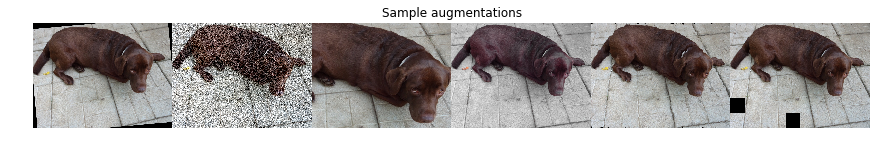

In [12]:
# get augmented images
image_rotated = rotate.augment_images([image])
image_noise = gaussian_noise.augment_images([image])
image_crop = crop.augment_images([image])
image_hue = hue.augment_images([image])
image_trans = elastic_trans.augment_images([image])
image_coarse = coarse_drop.augment_images([image])

# create an array of augmented images for the demo
images_aug = [image_rotated[0], image_noise[0], image_crop[0], image_hue[0], image_trans[0], image_coarse[0]]

# plot augmentation examples
plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.title('Sample augmentations')

Augmentation of an image with mask:

In [13]:
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage

# open image with mask and convert to binary map
pil_mask = Image.open('../input/mask1.png')
pil_mask = pil_mask.convert('RGB')

np_mask = np.array(pil_mask)
np_mask = np.clip(np_mask, 0, 1)

# create segmentation map for classes: background, dog
segmap = np.zeros(image.shape, dtype=bool)
segmap[:] = np_mask
segmap = SegmentationMapOnImage(segmap, shape=image.shape)

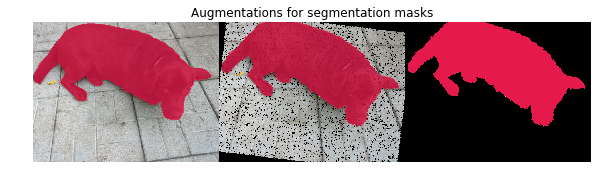

In [14]:
# initialize augmentations
seq = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.Affine(rotate=(-30, 30)),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])

# apply augmentation for image and mask
image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)

# visualize augmented image and mask
side_by_side = np.hstack([
    segmap.draw_on_image(image),
    segmap_aug.draw_on_image(image_aug),  # show blend of (augmented) image and segmentation map
    segmap_aug.draw()  # show only the augmented segmentation map
])

fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')
plt.title('Augmentations for segmentation masks')
ax.imshow(side_by_side)

Augmentation of an image with bounding box:

In [15]:
# import bounding boxes from imgaug
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [16]:
# initialize the bounding box for the original image
# using helpers from imgaug package
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=1, x2=980, y1=9, y2=535)
], shape=image.shape)

In [17]:
# define a simple augmentations pipeline for the image with bounding box
seq = iaa.Sequential([
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # translate the image
    iaa.Fliplr(p = 1.0) # apply horizontal flip
])

# apply augmentations
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

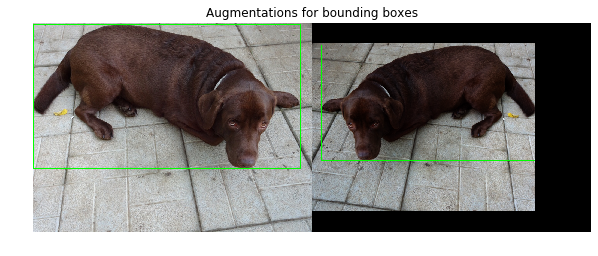

In [18]:
# plot the initial and the augmented images with bounding boxes
# using helpers from imgaug package
side_by_side = np.hstack([
    bbs.draw_on_image(image, size=2),
    bbs_aug.draw_on_image(image_aug, size=2)
])

fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')
plt.title('Augmentations for bounding boxes')
ax.imshow(side_by_side)

`2.` Example of data augmentation pipeline:

With the __imgaug__ library we can create a pipeline of image agumentations. Augmentations from the pipeline will be applied to each image sequentially, but we can set up:
1. The probability the augmentation will be applied to an image. We can use this to apply, for example, horizontal flip to just 50% of the images.
2. Apply only a subset of augmenters to an image. For example, apply 0 to 5 of augmenters from the list. This will help to speed up data generation.
3. Apply augmentations in random order.

Let's see an example:

In [19]:
# define an augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

# apply augmentation pipeline to sample image
images_aug = np.array([aug_pipeline.augment_image(image) for _ in range(16)])

In [20]:
# Helper function to display the images in a grid
# Source: https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
def gallery(array, ncols=3):
    '''
    Function to arange images into a grid.
    INPUT:
        array - numpy array containing images
        ncols - number of columns in resulting imahe grid
    OUTPUT:
        result - reshaped array into a grid with given number of columns
    '''
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

Text(0.5, 1.0, 'Augmentation pipeline examples')

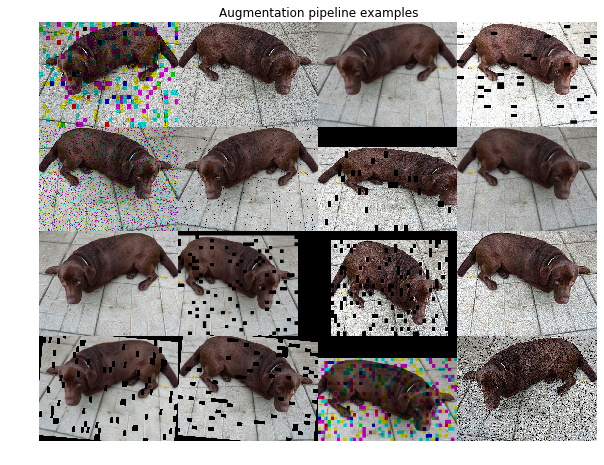

In [21]:
# visualize the augmented images
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')

`3.` Example of using __imgaug__ with PyTorch:

The following code snippet shows how __imgaug__ augmentations can be used in PyTorch dataset for generation of new augmented images:

In [22]:
# define train and test augmentations
AUG_TRAIN = aug_pipeline # use our pipeline as train augmentations
AUG_TEST = None # don't use any augmentations for test images

# Define the demo dataset
class DogDataset(Dataset):
    '''
    Sample dataset for imgaug demonstration.
    The dataset will consist of just one sample image.
    '''

    def __init__(self, image, augmentations = None):
        self.image = image
        self.augmentations = augmentations # save the augmentations

    def __len__(self):
        return 1 # return 1 as we have only one image

    def __getitem__(self, idx):
        # return the augmented image
        return TF.to_tensor(self.augmentations.augment_image(self.image))

In [23]:
# load the augmented data

# initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = DogDataset(image, augmentations = AUG_TRAIN)

# initilize the dataloader for training
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

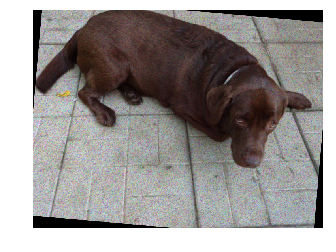

In [24]:
# get the augmented image from trainloader
# run this cell several times to produce different augmented images
for img in  trainloader:
    plt.axis('off')
    plt.imshow(TF.to_pil_image(img.reshape(3, 768, 1024))) # convert image to PIL from tensor with to_pil_image PyTorch helper

## Albumentations package

[Albumentations](https://github.com/albu/albumentations) package is based on numpy, OpenCV and imgaug. This is a very pipular package written by Kaggle masters and used widely in Kaggle competitions. Moreover, this package is very efficient. You may find the benchmarking results [here](https://github.com/albu/albumentations#benchmarking-results) and the full documentation for this package [here](https://albumentations.readthedocs.io/en/latest/).

Albumetations package is capable of:
* Over 60 pixel level and spatial level transformations;
* Transforming images with masks bounding boxes and keypoints;
* Organizing augmentations into pipelines;
* PyTorch integration.

`1.` Simple image augmentation examples:

Demonstration of single image augmentations:

Text(0.5, 1.0, 'Augmentation examples')

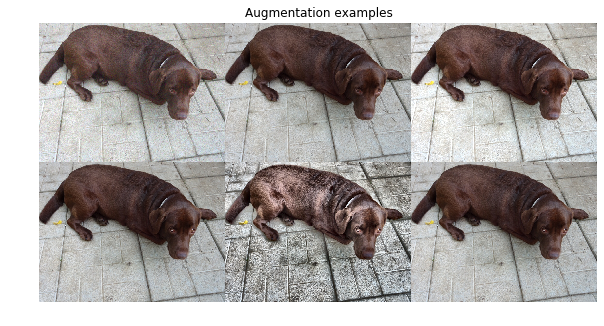

In [25]:
# import albumentations package
import albumentations as A

# initialize augmentations
gaus_noise = A.GaussNoise() # gaussian noise
elastic = A.ElasticTransform() # elastic transform
bright_contrast = A.RandomBrightnessContrast(p=1) # random brightness and contrast
gamma = A.RandomGamma(p=1) # random gamma
clahe = A.CLAHE(p=1) # CLAHE (see https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
blur = A.Blur()

# apply augmentations
# pass image to the augmentation
img_gaus = gaus_noise(image = image)
img_elastic = elastic(image = image)
img_bc = bright_contrast(image = image)
img_gamma = gamma(image = image)
img_clahe = clahe(image = image)
img_blur = blur(image = image)

# access the augmented image by 'image' key
img_list = [img_gaus['image'], img_elastic['image'], img_bc['image'], img_gamma['image'], img_clahe['image'], img_blur['image']]

# visualize the augmented images
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(np.array(img_list), ncols = 3))
plt.title('Augmentation examples')

Augmenting images with masks:

Text(0.5, 1.0, 'augmented mask')

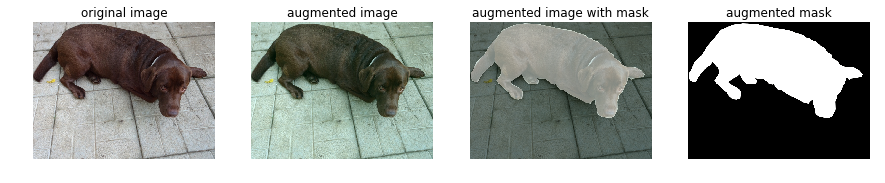

In [26]:
# compose augmentation pipeline
aug_pipeline = A.Compose([
    A.ShiftScaleRotate(),
    A.RGBShift(),
    A.Blur(),
    A.GaussNoise()
],p=1)

# load the mask
mask = imageio.imread('../input/mask1.png')
# apply augmentations to image and a mask
augmented = aug_pipeline(image = image, mask = mask)

# visualize augmented image and mask
fig, ax = plt.subplots(1,4, figsize = (15, 10))

ax[0].axis('off')
ax[0].imshow(image)
ax[0].set_title('original image')

ax[1].axis('off')
ax[1].imshow(augmented['image'])
ax[1].set_title('augmented image')

ax[2].axis('off')
ax[2].imshow(augmented['image'])
ax[2].imshow(augmented['mask'].squeeze(), alpha = 0.5, cmap = "Reds")
ax[2].set_title('augmented image with mask')

ax[3].axis('off')
ax[3].imshow(augmented['mask'].squeeze(), alpha = 1.0, cmap = "Reds")
ax[3].set_title('augmented mask')

Augmentation of images with bounding boxes:

In [27]:
# create bounding boxes from mask with cv2
import cv2
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
bboxes = cv2.boundingRect(cv2.findNonZero(mask))

Text(0.5, 1.0, 'augmented image')

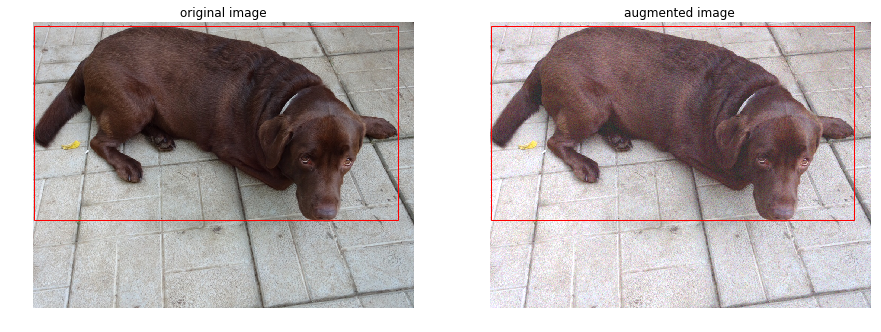

In [28]:
# compose augmentation pipeline
aug_pipeline = A.Compose([
    A.RGBShift(),
    A.Blur(),
    A.GaussNoise()
],p=1)

# augment image and bounding box
augmented_boxes = aug_pipeline(image = image, bboxes = [bboxes])
box_aug = augmented_boxes['bboxes'][0]

# visualize augmented image and bbox
fig, ax = plt.subplots(1,2, figsize = (15, 10))

ax[0].axis('off')
ax[0].imshow(image)
rect = patches.Rectangle((bboxes[0],bboxes[1]),bboxes[2] - bboxes[0],bboxes[3] - bboxes[1],linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('original image')

ax[1].axis('off')
ax[1].imshow(augmented_boxes['image'])
rect = patches.Rectangle((box_aug[0],box_aug[1]),box_aug[2] - box_aug[0],box_aug[3] - box_aug[1],linewidth=1,edgecolor='r',facecolor='none')
ax[1].add_patch(rect)
ax[1].set_title('augmented image')

`2.` Augmentation pipelines:

__Albumentations__ package allows to construct advanced pipelines similar to __imgaug__ pipelines.

Let's see an example (this example was inspired by [this kernel](https://www.kaggle.com/meaninglesslives/unet-plus-plus-with-efficientnet-encoder)):

In [29]:
# compose complex augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        A.OneOf(
            [
                # apply one of transforms to 50% images
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
            ],
            p = 0.5
        )
    ],
    p = 1
)

Text(0.5, 1.0, 'Augmentation pipeline examples')

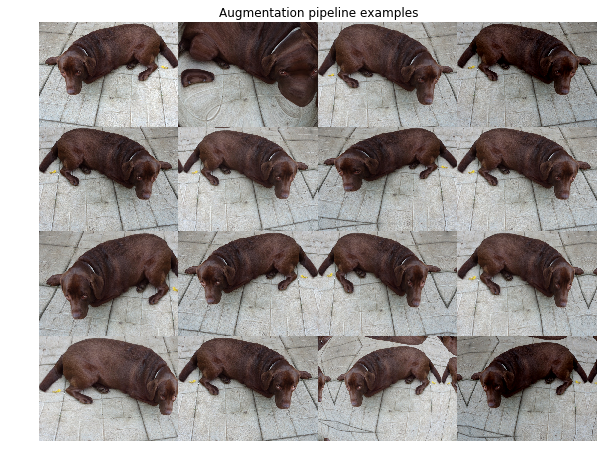

In [30]:
# apply pipeline to sample image
images_aug = np.array([augmentation_pipeline(image = image)['image'] for _ in range(16)])

# visualize augmentation results
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')

`3.` PyTorch integration example:

When using PyTorch you can effortlessly migrate from torchvision to __Albumentations__, because this package provides specialized utilities to be used with PyTorch. Migrating to __Albumentations__ will help to speed up the data generation part and train deep learning models faster. See detailed tutorial on migration from torchvision to __Albumentations__ [here](https://github.com/albu/albumentations/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb).

In [31]:
# import pytorch utilities from albumentations
from albumentations.pytorch import ToTensor

# define the augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        A.OneOf(
            [
                # apply one of transforms to 50% images
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
            ],
            p = 0.5
        ),
        
        # commented the normalization (which you will probably used for torchvision pretrained models)
        # because images look weird after normalization
        
        #A.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)

In [32]:
# load the augmented data

# Define the demo dataset
class DogDataset2(Dataset):
    '''
    Sample dataset for Albumentations demonstration.
    The dataset will consist of just one sample image.
    '''

    def __init__(self, image, augmentations = None):
        self.image = image
        self.augmentations = augmentations # save the augmentations

    def __len__(self):
        return 1 # return 1 as we have only one image

    def __getitem__(self, idx):
        # return the augmented image
        # no need to convert to tensor, because image is converted to tensor already by the pipeline
        augmented = self.augmentations(image = self.image)
        return augmented['image']

# initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = DogDataset2(image, augmentations = augmentation_pipeline)

# initilize the dataloader for training
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

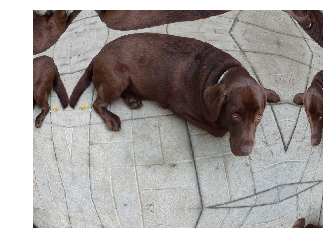

In [33]:
# get the augmented image from trainloader
# run this cell several times to produce different augmented images
for img in trainloader:
    plt.axis('off')
    plt.imshow(TF.to_pil_image(img.reshape(3, 768, 1024))) # convert image to PIL from tensor with to_pil_image PyTorch helper

## Augmentor package

__[Augmentor](https://github.com/mdbloice/Augmentor)__ package contains less possible augmentations than previous packages, but it has its own outstanding features like [size-preserving rotations](https://github.com/mdbloice/Augmentor#size-preserving-rotations), [size-preseving shearing](https://github.com/mdbloice/Augmentor#size-preserving-shearing) and [cropping](https://github.com/mdbloice/Augmentor#cropping), which is more suitable for machine learning.

__Augmentor__ package also allows to compose augmentation pipelines and use them with PyTorch. You can find the full documentation for __Augmentor__ package [here](https://augmentor.readthedocs.io/en/master/).

`1.` Simple image augmentation examples:

In [34]:
# import package
import Augmentor

# initialize pipeline
p = Augmentor.DataPipeline([[np.array(image), np.array(mask)]])

# apply augmentations
p.rotate(1, max_left_rotation=3, max_right_rotation=3)
p.shear(1, max_shear_left = 3, max_shear_right = 3)
p.zoom_random(1, percentage_area=0.9)

# sample from augmentation pipeline
images_aug = p.sample(1)

Text(0.5, 1.0, 'augmented mask')

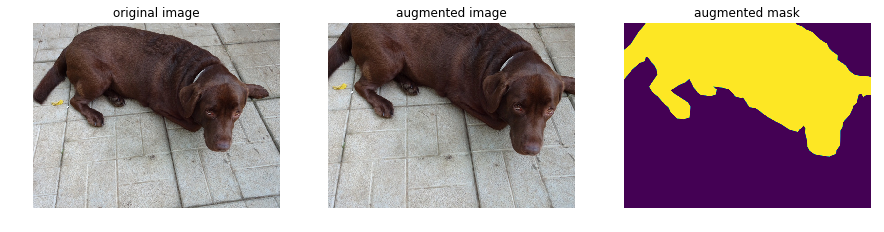

In [35]:
# visualize augmented image
augmented_image = images_aug[0][0]
augmented_mask = images_aug[0][1]

# visualize augmented image and mask
fig, ax = plt.subplots(1,3, figsize = (15, 10))

ax[0].axis('off')
ax[0].imshow(image)
ax[0].set_title('original image')

ax[1].axis('off')
ax[1].imshow(augmented_image)
ax[1].set_title('augmented image')

ax[2].axis('off')
ax[2].imshow(augmented_mask)
ax[2].set_title('augmented mask')

`2.` Example of using __Augmentor__ with PyTorch:

There are some [known issues](https://github.com/mdbloice/Augmentor/issues/109) with __Augmentor__ and PyTorch, but we can still use these libraries together.

Here is an example:

In [36]:
# load the augmented data

# Define the demo dataset
class DogDataset3(Dataset):
    '''
    Sample dataset for Augmentor demonstration.
    The dataset will consist of just one sample image.
    '''

    def __init__(self, image):
        self.image = image

    def __len__(self):
        return 1 # return 1 as we have only one image

    def __getitem__(self, idx):
        # return the augmented image
        # no need to convert to tensor, because image is converted to tensor already by the pipeline
        
        # initialize the pipeline
        p = Augmentor.DataPipeline([[np.array(image)]])

        # apply augmentations
        p.rotate(0.5, max_left_rotation=10, max_right_rotation=10) # rotate the image with 50% probability
        p.shear(0.5, max_shear_left = 10, max_shear_right = 10) # shear the image with 50% probability
        p.zoom_random(0.5, percentage_area=0.7) # zoom randomly with 50% probability

        # sample from augmentation pipeline
        images_aug = p.sample(1)
        
        # get augmented image
        augmented_image = images_aug[0][0]
        
        # convert to tensor and return the result
        return TF.to_tensor(augmented_image)

# initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = DogDataset3(image)

# initilize the dataloader for training
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

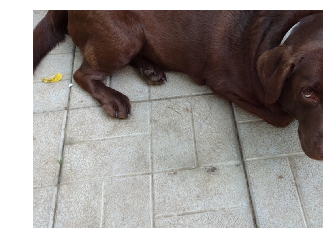

In [37]:
# get the augmented image from the trainloader
# run this cell several times to produce different augmented images
for img in trainloader:
    plt.axis('off')
    plt.imshow(TF.to_pil_image(img.reshape(3, 768, 1024))) # convert image to PIL from tensor with to_pil_image PyTorch helper

## Conclusion

In this kernel:
* I described the main features of imgaug, Albumentations and Augmentor packages for image augmentation designed for machine learning;
* I demonstrated how to use the packages for augmentation of images with masks and bounding boxes;
* I demonstrated how to use the packages with PyTorch deep learning framework.

## Additional References and Credits
1. [Unet Plus Plus with EfficientNet Encoder](https://www.kaggle.com/meaninglesslives/unet-plus-plus-with-efficientnet-encoder) - Kaggle kernel, which uses __Albumentations__ for xray image augmentation with Keras library.
2. [Example](https://github.com/neptune-ml/open-solution-mapping-challenge/blob/master/src/augmentation.py) of usage of __imgaug__ for [Crowd AI mapping challenge](https://www.crowdai.org/challenges/mapping-challenge).
3. Very informative Medium [Data Augmentation article](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced).